## Load IFS from Intake catalogue

### load Tco3999-NG5 (hr0n), Tco2559-NG5 (hqys), and Tco1279-orca025 (hr2n)

In [22]:
import intake
import numpy as np

In [11]:
variable="sst"

In [12]:
catalog_file = "/work/ka1081/Catalogs/dyamond-nextgems.json"
cat = intake.open_esm_datastore(catalog_file)

In [14]:
hits = cat.search(simulation_id=["HR0N","HQYS","HR2N"], variable_id=variable, frequency="1hour", realm="atm")

In [15]:
dataset_dict = hits.to_dataset_dict(cdf_kwargs={"chunks": {"time": 1}})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'project.institution_id.source_id.experiment_id.simulation_id.realm.frequency.time_reduction.grid_label.level_type'


/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/intake_esm/merge_util.py:270: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  ds = xr.open_zarr(path, **zarr_kwargs)


In [16]:
dataset_dict

{'nextGEMS.ECMWF-AWI.IFS-FESOM.nextgems_cycle2.HQYS.atm.1hour.inst-or-acc.gn.2d': <xarray.Dataset>
 Dimensions:  (time: 8329, value: 26306560)
 Coordinates:
     lat      (value) float64 dask.array<chunksize=(26306560,), meta=np.ndarray>
     lon      (value) float64 dask.array<chunksize=(26306560,), meta=np.ndarray>
   * time     (time) datetime64[ns] 2020-01-20 2020-01-20T01:00:00 ... 2021-01-01
 Dimensions without coordinates: value
 Data variables:
     sst      (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
 Attributes:
     edition:                 1
     centre:                  ecmf
     centreDescription:       European Centre for Medium-Range Weather Forecasts
     subCentre:               0
     history:                 🪄🧙‍♂️🔮 magic dataset assembly provided by gribsc...
     intake_esm_varname:      ['sst']
     intake_esm_dataset_key:  nextGEMS.ECMWF-AWI.IFS-FESOM.nextgems_cycle2.HQY...,
 'nextGEMS.ECMWF-AWI.IFS-FESOM.nextgems_cycle2.HR0N.atm.1h

In [17]:
keys = list(dataset_dict.keys())
keys

['nextGEMS.ECMWF-AWI.IFS-FESOM.nextgems_cycle2.HQYS.atm.1hour.inst-or-acc.gn.2d',
 'nextGEMS.ECMWF-AWI.IFS-FESOM.nextgems_cycle2.HR0N.atm.1hour.inst-or-acc.gn.2d',
 'nextGEMS.ECMWF-AWI.IFS-FESOM.nextgems_cycle2.HR2N.atm.1hour.inst-or-acc.gn.2d']

In [19]:
ds_tco2559 = dataset_dict[keys[0]] # 4km example
ds_tco3999 = dataset_dict[keys[1]] # 2.5km example
ds_tco1279 = dataset_dict[keys[2]] # 9km baseline

## plot one of the experiments

In [38]:
import matplotlib.pylab as plt
import matplotlib.cm as cm
import cartopy.crs as ccrs

In [39]:
ds = ds_tco2559 # 4km example

In [40]:
# Extract lat,lon and time
time=ds.time.values
model_lon = ds.lon.values
model_lat = ds.lat.values

#### plotting a map

In [41]:
# select a date, and convert to deg C
data_sample = ds.sst.sel(time='2020-02-02-00:00:00') - 273.15

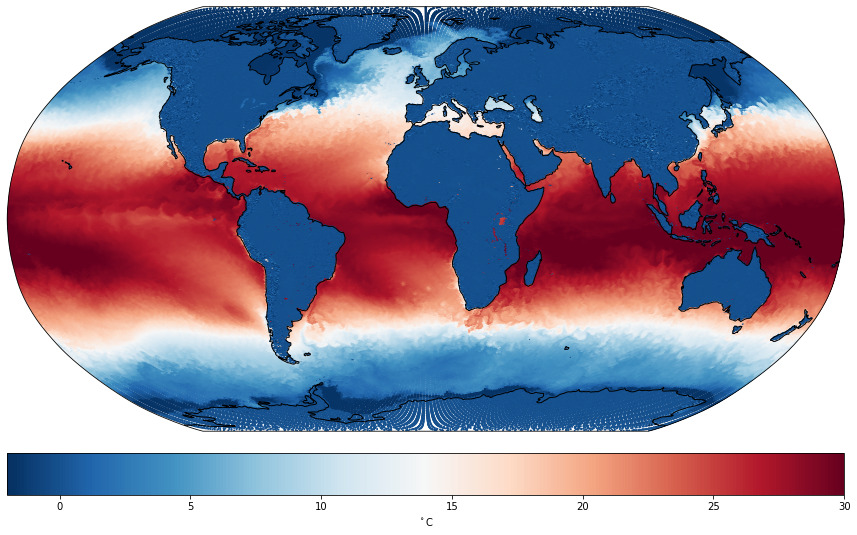

In [43]:
# sstep controls the spacing between points to plot
sstep=48

# plot using the simple scatter method:
plt.figure(figsize=(15,10))
# plot using Robinson projection.
#ax = plt.axes(projection=ccrs.PlateCarree())
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines(resolution='110m', color='k')

sc=ax.scatter(model_lon[::sstep], model_lat[::sstep], s=1 , c=data_sample[::sstep],cmap=cm.RdBu_r, transform=ccrs.PlateCarree(), vmin=-2.,vmax=30.)
# Add colorbar
cbar=plt.colorbar(sc,orientation='horizontal', pad=0.04)
cbar.set_label('$^\circ$C')
#plt.clim(-20, 29.) 

#### plotting a box

In [44]:
lonmin, lonmax = -20., 0.
latmin, latmax = -3. , 3.

In [45]:
IND1 = np.logical_and(lonmin <= model_lon, model_lon <= lonmax)
IND2 = np.logical_and(latmin <= model_lat, model_lat <= latmax)
INDbox = np.logical_and(IND1, IND2)

In [48]:
box_ifs = ds.sst[:,INDbox].mean(axis=1).groupby('time.month').mean().compute()

##### save to netCDF

In [49]:
box_ifs.to_netcdf('box_ifs.nc')

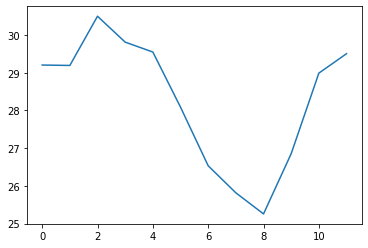

In [50]:
plt.plot(box_ifs - 273.15)